In [1]:
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers
from keras.preprocessing import *
from sklearn.model_selection import train_test_split


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

In [4]:
os.listdir()

['.config', 'drive', 'sample_data']

In [5]:
df_train = pd.read_csv("drive/MyDrive/train_cleaned_vec.csv", index_col = 0)
df_test = pd.read_csv("drive/MyDrive/test_cleaned_vec.csv", index_col = 0)

dfs = [df_train, df_test]
df = pd.concat(dfs)


In [6]:
# Shuffle data to remove any bias present in order
df = df.sample(frac = 1)

# Reset index and drop original index column
df = df.reset_index(drop = True)

df.head()

,label,text,label_str,tokenized_text,word_vector,doc_vector
0,5,urodynamic morbidity dysuria prophylaxis group...,pathological,"['urodynamic', 'morbidity', 'dysuria', 'prophy...",[-0.51320714 -0.04813077 -0.3158617 0.499952...,[-0.14163868 -0.13445656 -0.06472661 0.088845...
1,1,lack effect pregnancy outcome melanoma world h...,neoplasms,"['lack', 'effect', 'pregnancy', 'outcome', 'me...",[-0.6884897 -0.338992 -0.37078735 0.623095...,[-0.22766767 -0.4249245 -0.14566635 0.116552...
2,5,exposure intracavernous carotid artery aneurys...,pathological,"['exposure', 'intracavernous', 'carotid', 'art...",[ 2.4191120e-01 2.2851223e-01 5.5464220e-01 ...,[ 0.1539317 0.33731422 0.67510664 -0.407551...
3,4,coronary blood flow dogs contractile dysfuncti...,cardiovascular,"['coronary', 'blood', 'flow', 'dogs', 'contrac...",[-0.01340567 0.50977886 0.3093509 0.144892...,[ 0.24902238 0.23159806 0.84016675 -0.072435...
4,1,ectatic blood vessels port wine stains lack in...,neoplasms,"['ectatic', 'blood', 'vessels', 'port', 'wine'...",[-0.13627407 0.23747823 0.0885198 0.026780...,[ 0.0532054 0.12003578 0.40478513 -0.269387...


In [7]:
df['word_vector'][0]

'[-0.51320714 -0.04813077 -0.3158617   0.4999527   0.10472398 -0.4908846\n -0.20128243  0.5705389  -0.5066127  -0.07913493 -0.44793218 -0.48044035\n -0.45580012  0.29406986  0.1349332  -0.3520766   0.12295035 -0.36768267\n -0.57357484 -0.37362012  0.27310658 -0.11942487  0.34720483  0.07055093\n  0.12284914 -0.4858754   0.08692607  0.03522979 -0.54353917  0.29292253\n  0.52603596 -0.10931839  0.12272995 -0.19820818 -0.39421135  0.5191129\n -0.03787661 -0.33857107 -0.2360404  -0.40692773 -0.09825405  0.089826\n -0.48992342 -0.23075089  0.05439727  0.25674006 -0.23755427 -0.01047419\n  0.40599602  0.22175498  0.08728024 -0.4738247  -0.06205064 -0.22610757\n -0.02089396  0.15591118 -0.1619441  -0.18166625 -0.47754517  0.5790612\n -0.05873791  0.34384194  0.13766347 -0.35705188 -0.4199193   0.33278316\n  0.09566639  0.31994635 -0.55921423  0.5996269  -0.13108085  0.300816\n  0.30241376  0.16032863  0.04121322  0.28971606 -0.05739846  0.0809987\n -0.37519836 -0.23933645 -0.15257701 -0.06475

## Word2Vec and Doc2Vec

In [33]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['tokenized_text'].tolist(), vector_size=100, window=5, min_count=2, workers=4)

# Create a function to average Word2Vec vectors for each document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0

    for word in words:
        if word in vocabulary:
            nwords += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Apply function to each row in the DataFrame
vocabulary = set(word2vec_model.wv.index_to_key)
df['word_vec'] = df['tokenized_text'].apply(lambda x: average_word_vectors(x, word2vec_model, vocabulary, 100))


In [34]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Tagging documents
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df['tokenized_text'])]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=2, workers=4)

# Save the vectors to DataFrame
df['doc_vec'] = [doc2vec_model.dv[str(i)] for i in range(len(df))]


In [10]:
df['word_vec'].shape

(14438,)

In [11]:
df['word_vec'][6].shape

(100,)

In [12]:
target = df["label_str"]

# one hot encode target
y = pd.get_dummies(target).values

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(df['text']))
tokenized_texts = tokenizer.texts_to_sequences(df['text'])
X = tf.keras.preprocessing.sequence.pad_sequences(tokenized_texts)

In [13]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (14438, 376)
Shape of y: (14438, 5)


In [14]:
X_word_vec = np.array(list(df['word_vector']))
X_doc_vec = np.array(list(df['doc_vector']))

In [15]:
nltk.download('punkt')

NameError: name 'nltk' is not defined

In [16]:
X_word_vec.shape

(14438,)

In [17]:
X_doc_vec.shape

(14438,)

In [18]:
    # Stack arrays correctly
    X = np.array(list(df['doc_vector']))
    print("New shape of X:", X.shape) ## Shouldn't be one dimensional??

New shape of X: (14438,)


## RNN #1: Doc2Vec

In [19]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['doc_vec'].values)

# Add an explicit timestep dimension
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Shape of X after reshaping:", X.shape)

Shape of X after reshaping: (14438, 1, 100)


In [20]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label_str'])
# Convert labels to categorical
y = to_categorical(encoded_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (11550, 1, 100)
Shape of y_train: (11550, 5)


In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
# works the best
# Initialize the model
model = Sequential()

# Adding LSTM layer
model.add(LSTM(64, input_shape=(1, 100)))  # Shape [timesteps, features]

# Adding dropout for regularization
model.add(Dropout(0.5))

# Adding a Dense layer for classification
model.add(Dense(5, activation='softmax'))  # 5 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 5)                 325       
                                                                 
Total params: 42565 (166.27 KB)
Trainable params: 42565 (166.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Initialize the model
model = Sequential()

# Adding LSTM layer
model.add(LSTM(64, input_shape=(1, 100)))  # Shape [timesteps, features]

# Adding dropout for regularization
model.add(Dropout(0.5))

# Adding a Dense layer for classification
model.add(Dense(5, activation='softmax'))  # 5 classes

model.add(Dropout(0.25))
model.add(Dense(5, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                42240     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 5)                 325       
                                                                 
 dropout_18 (Dropout)        (None, 5)                 0         
                                                                 
 dense_12 (Dense)            (None, 5)                 30        
                                                                 
Total params: 42595 (166.39 KB)
Trainable params: 42595 (166.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# Initialize the model
model = Sequential()

# best performing model
# Adding stacked LSTM layers
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(128, input_shape=(1, 100), return_sequences=True))
model.add(Dropout(0.2))  # Slightly lower dropout rate

# Second LSTM layer, no need to return sequences since the next layer is a Dense layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))  # Consistent dropout rate to prevent overfitting

# Adding a Dense layer for classification
model.add(Dense(5, activation='softmax'))

# Compile the model with a possibly adjusted optimizer
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 128)            117248    
                                                                 
 dropout_19 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_21 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 5)                 325       
                                                                 
Total params: 166981 (652.27 KB)
Trainable params: 166981 (652.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
from tensorflow.keras.callbacks import EarlyStopping

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

# train the model with early stopping
history = model.fit(X_train, y_train,
          epochs=20,
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stopping])

Epoch 1/20
325/325 [==============================] - 2s 6ms/step - loss: 1.4455 - accuracy: 0.3717 - val_loss: 1.5072 - val_accuracy: 0.3420
Epoch 2/20
325/325 [==============================] - 2s 5ms/step - loss: 1.4406 - accuracy: 0.3716 - val_loss: 1.5133 - val_accuracy: 0.3429
Epoch 3/20
325/325 [==============================] - 2s 6ms/step - loss: 1.4390 - accuracy: 0.3739 - val_loss: 1.5072 - val_accuracy: 0.3489
Epoch 4/20
325/325 [==============================] - 2s 5ms/step - loss: 1.4365 - accuracy: 0.3757 - val_loss: 1.5064 - val_accuracy: 0.3359
Epoch 5/20
325/325 [==============================] - 2s 6ms/step - loss: 1.4333 - accuracy: 0.3766 - val_loss: 1.5116 - val_accuracy: 0.3377
Epoch 6/20
325/325 [==============================] - 2s 6ms/step - loss: 1.4328 - accuracy: 0.3743 - val_loss: 1.5091 - val_accuracy: 0.3420
Epoch 7/20
325/325 [==============================] - 2s 6ms/step - loss: 1.4266 - accuracy: 0.3804 - val_loss: 1.5071 - val_accuracy: 0.3368
Epoch 

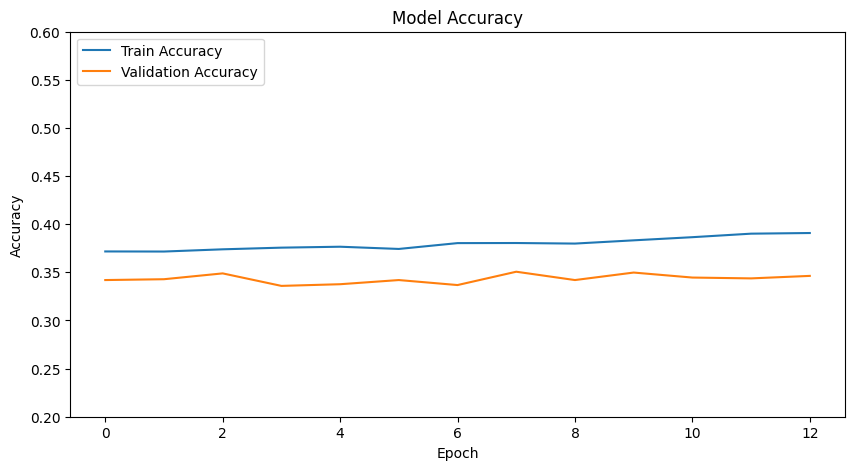

In [64]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.2,0.6])
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [65]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

91/91 [==============================] - 0s 3ms/step - loss: 1.4881 - accuracy: 0.3563
Test Loss: 1.4881010055541992
Test Accuracy: 0.3563019335269928


## RNN #2: Word2Vec

In [21]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['word_vec'].values)

# Add an explicit timestep dimension
X = X.reshape((X.shape[0], 1, X.shape[1]))
print("Shape of X after reshaping:", X.shape)

Shape of X after reshaping: (14438, 1, 100)


In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Label encoding
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label_str'])
# Convert labels to categorical
y = to_categorical(encoded_labels)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (11550, 1, 100)
Shape of y_train: (11550, 5)


In [ ]:
from sklearn.model_selection import train_test_split
from nltk import word_tokenize


data = df['text'].map(nltk.word_tokenize).values
total_vocabulary = set(word.lower() for text in data for word in text)  # set created from nested comprehension

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))  # use 5 because we have 5 categories

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary() # check the shape


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         4460416   
                                                                 
 lstm_1 (LSTM)               (None, None, 25)          15400     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 25)                0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                1300      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                      

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# configure early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

# train the model with early stopping
history = model.fit(X_train, y_train,
          epochs=10,
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stopping])

Epoch 1/10
325/325 [==============================] - 28s 78ms/step - loss: 1.3665 - accuracy: 0.4321 - val_loss: 1.1358 - val_accuracy: 0.5723
Epoch 2/10
325/325 [==============================] - 13s 39ms/step - loss: 1.0921 - accuracy: 0.5608 - val_loss: 1.0610 - val_accuracy: 0.5645
Epoch 3/10
325/325 [==============================] - 9s 27ms/step - loss: 0.9283 - accuracy: 0.6203 - val_loss: 1.0143 - val_accuracy: 0.5758
Epoch 4/10
325/325 [==============================] - 7s 23ms/step - loss: 0.8094 - accuracy: 0.6735 - val_loss: 1.1227 - val_accuracy: 0.5593
Epoch 5/10
325/325 [==============================] - 7s 21ms/step - loss: 0.7213 - accuracy: 0.7142 - val_loss: 1.1650 - val_accuracy: 0.5619
Epoch 6/10
325/325 [==============================] - 6s 18ms/step - loss: 0.6359 - accuracy: 0.7512 - val_loss: 1.1985 - val_accuracy: 0.5593
Epoch 7/10
325/325 [==============================] - 5s 16ms/step - loss: 0.5949 - accuracy: 0.7605 - val_loss: 1.4177 - val_accuracy: 0.54

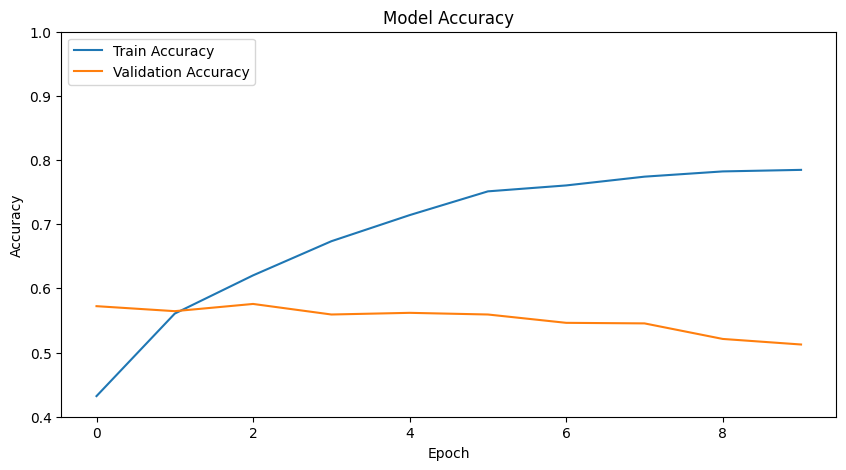

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim([0.4,1])
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

91/91 [==============================] - 1s 7ms/step - loss: 1.7063 - accuracy: 0.4976
Test Loss: 1.7062660455703735
Test Accuracy: 0.49757617712020874


## XGBoost: Word2Vec

In [40]:
df.head()

,label,text,label_str,tokenized_text,word_vector,doc_vector,word_vec,doc_vec
0,5,urodynamic morbidity dysuria prophylaxis group...,pathological,"['urodynamic', 'morbidity', 'dysuria', 'prophy...",[-0.51320714 -0.04813077 -0.3158617 0.499952...,NaN,"[0.1321849081852644, 0.25502895861423225, 0.19...","[0.16542488, -0.013994893, -0.021934466, 0.103..."
1,1,lack effect pregnancy outcome melanoma world h...,neoplasms,"['lack', 'effect', 'pregnancy', 'outcome', 'me...",[-0.6884897 -0.338992 -0.37078735 0.623095...,NaN,"[0.14289511329973276, 0.25436502934135646, 0.2...","[0.018436024, 0.13624802, -0.10810895, 0.09810..."
2,5,exposure intracavernous carotid artery aneurys...,pathological,"['exposure', 'intracavernous', 'carotid', 'art...",[ 2.4191120e-01 2.2851223e-01 5.5464220e-01 ...,NaN,"[0.155448986670824, 0.28675772562450286, 0.246...","[0.4275761, 0.07218752, 0.0123384185, -0.13535..."
3,4,coronary blood flow dogs contractile dysfuncti...,cardiovascular,"['coronary', 'blood', 'flow', 'dogs', 'contrac...",[-0.01340567 0.50977886 0.3093509 0.144892...,NaN,"[0.16296972926514555, 0.28471106704386406, 0.2...","[0.30512378, 0.16227414, 0.17712279, 0.0602712..."
4,1,ectatic blood vessels port wine stains lack in...,neoplasms,"['ectatic', 'blood', 'vessels', 'port', 'wine'...",[-0.13627407 0.23747823 0.0885198 0.026780...,NaN,"[0.16248775945891528, 0.2801855075094291, 0.21...","[0.19259657, 0.19672395, 0.118724726, 0.130381..."


In [42]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['word_vec'].values)

In [44]:
X.shape

(14438, 100)

In [48]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

labels = df['label'] - 1

# Split into train and test sets
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, labels_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 23.68%


In [38]:
X_train.shape

(11550,)

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(xgb.XGBClassifier(n_jobs=-1), parameters, cv=3, scoring='accuracy')
grid_search.fit(X_train, labels_train)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'learning_rate': 0.2, 'max_depth': 3}


## XGBoost: Doc2Vec

In [49]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['doc_vec'].values)

In [50]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

labels = df['label'] - 1

# Split into train and test sets
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, labels_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(labels_test, predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 33.17%


## Naive Bayes: Word2Vec

In [52]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['word_vec'].values)

In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB  # Using GaussianNB because vectors are continuous

# if isinstance(df['doc_vector'].iloc[0], list):
#     df['doc_vector'] = df['doc_vector'].apply(np.array)

# X = np.stack(df['doc_vector'])
labels = df['label'] - 1

# Split into train and test sets
X_train, X_test, labels_train, labels_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Using Gaussian Naive Bayes for continuous features
clf = GaussianNB()
clf.fit(X_train, labels_train)
labels_pred = clf.predict(X_test)
accuracy = accuracy_score(labels_test, labels_pred)
print(f"Accuracy with Word2Vec: {accuracy}")


Accuracy with Word2Vec: 0.2884349030470914


## Naive Bayes: Word2Vec

In [57]:
# Convert the list of vectors into a single numpy array
X = np.stack(df['doc_vec'].values)

In [55]:
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

# text data and labels
texts = df['text']
labels = df['label']

labels = labels - 1

# split into train and test sets
texts_train, texts_test, labels_train, labels_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# convert data
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

clf.fit(X_train, labels_train)

MultinomialNB()

In [56]:
print(f"Accuracy with Doc2Vec: {clf.score(X_test, labels_test)}")

Accuracy with Doc2Vec: 0.5166204986149584


In [60]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/5400_models.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/5400_models.ipynb to html
[NbConvertApp] Writing 760347 bytes to /content/drive/MyDrive/5400_models.html
